<a href="https://colab.research.google.com/github/cjrincon/Proyecto_Deep_Learning/blob/main/02_Arquitectura_de_linea_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predecir la capacidad de la batería**

Se plantean diferentes modelos para hacer la predicción de la capacidad de la batería.

Como datos de train y test, se toman los datos de 3 baterías y 1 conjunto de datos de otra batería para la validación.

## Cargar las librerías necesarias para el desarrollo del proyecto

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math, statistics

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Lectura de los datos, identificación de cada batería y cálculo del SOH

In [ ]:
# Lectura de datos desde github
# Datos de la batería #5
url_5 = 'https://raw.githubusercontent.com/cjrincon/Proyecto_Deep_Learning/main/data/raw_data_05.csv'
bat_5 = pd.read_csv(url_5, delimiter=',')
# Datos de la batería #6
url_6 = 'https://raw.githubusercontent.com/cjrincon/Proyecto_Deep_Learning/main/data/raw_data_06.csv'
bat_6 = pd.read_csv(url_6, delimiter=',')
# Datos de la batería #7
url_7 = 'https://raw.githubusercontent.com/cjrincon/Proyecto_Deep_Learning/main/data/raw_data_07.csv'
bat_7 = pd.read_csv(url_7, delimiter=',')
# Datos de la batería #18
url_18 = 'https://raw.githubusercontent.com/cjrincon/Proyecto_Deep_Learning/main/data/raw_data_18.csv'
bat_18 = pd.read_csv(url_18, delimiter=',')

In [ ]:
# Se agrega una columna para identificar cada tipo de batería
bat_5 = bat_5.assign(battery=5)
bat_6 = bat_6.assign(battery=6)
bat_7 = bat_7.assign(battery=7)
bat_18 = bat_18.assign(battery=18)

In [ ]:
# Se crea una base de datos consolidando los datos de las 4 baterías
data = pd.concat([bat_5, bat_6, bat_7, bat_18])
data.head()

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery
0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,5
1,1,24,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,5
2,1,24,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,5
3,1,24,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,5
4,1,24,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,5


In [ ]:
# Se calcula el SOH según la fórmula anterior
bat_5['SOH'] = bat_5['capacity']/bat_5['capacity'][0]
bat_6['SOH'] = bat_6['capacity']/bat_5['capacity'][0]
bat_7['SOH'] = bat_7['capacity']/bat_5['capacity'][0]
bat_18['SOH'] = bat_18['capacity']/bat_5['capacity'][0]
data = pd.concat([bat_5, bat_6, bat_7, bat_18])

In [ ]:
# Creación del nuevo dataset usando el promedio de las variables
dataset_mean = data.groupby(by=['battery', 'cycle'])[['temperature_measured', 'voltage_measured', 'current_measured', 'voltage_load', 'current_load', 'SOH']].mean()
dataset_mean['capacity'] = data.groupby(by=['battery','cycle'])['capacity'].mean()
dataset_mean = dataset_mean.reset_index()

In [ ]:
# Creación del nuevo dataset usando la mediana de las variables
dataset_median = data.groupby(by=['battery', 'cycle'])[['temperature_measured', 'voltage_measured', 'current_measured', 'voltage_load', 'current_load', 'SOH']].median()
dataset_median['capacity'] = data.groupby(by=['battery','cycle'])['capacity'].median()
dataset_median = dataset_median.reset_index()

### Definición de funciones importantes para la visualización

In [ ]:
# Función para calcular el error
def error(modelo, X_test, y_test):
  np.random.seed(0)
  # Se realizan las predicciones
  pred = modelo.predict(X_test)
  
  # Se evalua el RMSE
  rmse = math.sqrt(mean_squared_error(y_test, pred))
  print("RMSE para los datos es: {}.".format(rmse))

In [ ]:
# Función para graficar el test del modelo
def grafico(modelo, X_test, y_test):
  np.random.seed(0)
  pred = modelo.predict(X_test)
  # Se visualizan los resultados
  plt.figure(figsize=(12, 6))
  plt.plot(y_test, color='green',label='Real')
  plt.plot(pred, color='blue',label='Predicción')
  plt.title('Predicción')
  plt.xlabel('Muestras')
  plt.ylabel('Capacity')
  plt.legend()
  plt.show()

In [ ]:
# Función para graficar según el modelo entrenado la predicción para cada batería
def grafico_bat(modelo):
  np.random.seed(0)
  datos_pred = [X_valid, X_bat6, X_bat7, X_bat18]
  datos_real = [y_valid, y_bat6, y_bat7, y_bat18]
  baterias = [5, 6, 7, 18]  
  j, k = 0,0
  fig, ax =plt.subplots(2,2)

  for i in range(len(datos_pred)):
    pred_ini = modelo.predict(datos_pred[i])

    rmse = math.sqrt(mean_squared_error(datos_real[i], pred_ini))
    print("RMSE para batería #" + str(baterias[i]) + " es: {}.".format(rmse))

    if i == 0: j, k = 0,0
    elif i == 1: j, k = 0, 1
    elif i == 2: j, k = 1, 0
    else: j, k = 1, 1

    fig.set_size_inches(12, 6)
    ax[j,k].plot(datos_real[i], color='green', label=('Real'))
    ax[j,k].plot(pred_ini, color='orange', label='Predicción')
    ax[j,k].set_title('Predicción batería #' + str(baterias[i]))
    ax[j,k].set_xlabel('Cycle')
    ax[j,k].set_ylabel('Capacity')
    ax[j,k].legend()
    fig.tight_layout()

## División de los datos: creando un dataset con la media y un dataset con la mediana

Se plantean 2 tipos de dataset:

1. Usando el promedio de las variables medidas: corriente, voltaje y temperatura, y las variables de carga: corriente y voltaje.

2. Usando la mediana de las variables medidas: corriente, voltaje y temperatura, y las variables de carga: corriente y voltaje.


Se toman los datos de las baterías #6, #7, #18, para hacer el entrenamiento y test y el conjunto de datos de la batería #5 se deja para hacer la validación.

In [ ]:
# Filtrar las baterías 6, 7, 18 para el train y test
datos_modelo = dataset_mean[dataset_mean['battery'] > 5]

In [ ]:
features = ['cycle', 'temperature_measured','voltage_measured','current_measured','voltage_load','current_load','SOH', 'capacity']
train, test = train_test_split(datos_modelo[features], test_size = 0.30, random_state = 100)

In [ ]:
print('Forma train:', train.shape, 'Forma test:', test.shape)

Forma train: (327, 8) Forma test: (141, 8)


In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_n = scaler.fit_transform(train)
test_n = scaler.transform(test)

In [ ]:
# Se definen los datos de entrenamiento en: Predictores y predicho
X_train = train_n[:, :7]
y_train = train_n[:,7:8]

In [ ]:
# Se definen los datos de test en: Predictores y predicho
X_test = test_n[:, :7]
y_test = test_n[:,7:8]

In [ ]:
# Se valida la forma de cada uno de los datos de entrenamiento y test
print('X train:', X_train.shape, 'y train:', y_train.shape)
print('X test:', X_test.shape, 'y test:', y_test.shape)

X train: (327, 7) y train: (327, 1)
X test: (141, 7) y test: (141, 1)


In [ ]:
# Datos de validación con la batería 5
datos_valid = dataset_mean[dataset_mean['battery'] == 5]
datos_valid = datos_valid[features]

In [ ]:
# Se normaliza el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
validation = scaler.fit_transform(datos_valid)
validation.shape

(168, 8)

In [ ]:
# Se hace la división de los datos
X_valid = validation[:, :7]
y_valid = validation[:,7:8]

In [ ]:
# Se valida la forma de cada uno de los datos de entrenamiento y test
print(X_valid.shape, y_valid.shape)

(168, 7) (168, 1)


In [ ]:
# Para validar resultados con los datos de las baterías
# Datos de la batería 6
datos_6 = dataset_mean[dataset_mean['battery'] == 6]
datos_6 = datos_6[features]
# Se normaliza el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
val_6 = scaler.fit_transform(datos_6)
# Se hace la división de los datos
X_bat6 = val_6[:, :7]
y_bat6 = val_6[:,7:8]

In [ ]:
# Datos de la batería 7
datos_7 = dataset_mean[dataset_mean['battery'] == 7]
datos_7 = datos_7[features]
# Se normaliza el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
val_7 = scaler.fit_transform(datos_7)
# Se hace la división de los datos
X_bat7 = val_7[:, :7]
y_bat7 = val_7[:,7:8]

In [ ]:
# Datos de la batería 18
datos_18 = dataset_mean[dataset_mean['battery'] == 18]
datos_18 = datos_18[features]
# Se normaliza el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
val_18 = scaler.fit_transform(datos_18)
# Se hace la división de los datos
X_bat18 = val_18[:, :7]
y_bat18 = val_18[:,7:8]

## Implementación de los modelos a partir del dataset con el **promedio de los datos**

Se plantean 3 modelos de predicción para hacer una exploración con diferentes tipos de modelos.

1. Modelo con capas densas (Dense)
2. Modelo con capas LSTM (LSTM)
3. Modelo con capa recurrente (SimpleRNN)


Inicialmente, se plantean 3 tipos de modelos usando los datos del promedio de las variables de corriente, voltaje y temperatura. En esta sección, se pretende validar los resultados de cada uno de los modelos planteados anteriormente con el dataset que incluye los datos del promedio de las variables.

### *Modelo con capas densas y los datos con el promedio*

In [ ]:
# Modelo con capas densas
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Se compila el modelo
model.compile(optimizer='adam', loss='mean_absolute_error')

In [ ]:
# Se entrena el modelo
model.fit(x=X_train, y=y_train, batch_size=25, epochs=50, verbose = False)

RMSE para los datos es: 0.0916364316762448.


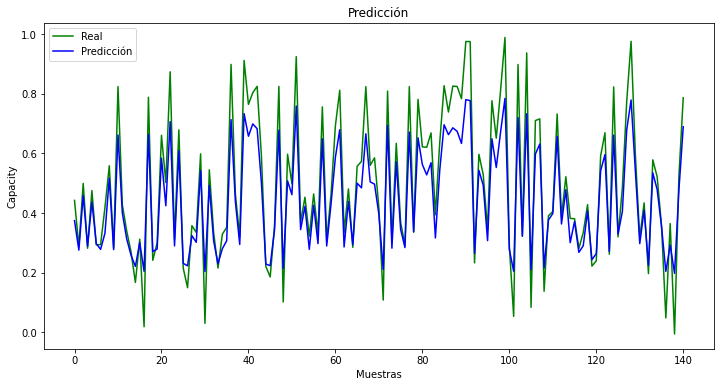

In [ ]:
# Datos de test
error(model, X_test, y_test)
grafico(model, X_test, y_test)

Con el modelo inicial, de 145 parámetros, se obtiene un valor del RMSE inferior al 10%. Gráficamente se observa que los valores reales versus los valores predichos en cada una de las muestras de capacidad, se ajusta adecuadamente, sin embargo, se observa que con el modelo no se ajusta muy bien a los picos que se presentan en cada una de las muestras.

Se hace la evaluación del modelo entrenado con los datos de validación y se hace la predicción para cada una de las baterías y validar su ajuste.

### Evaluación del modelo entrenado con los datos de validación

RMSE para los datos es: 0.15882238651485242.


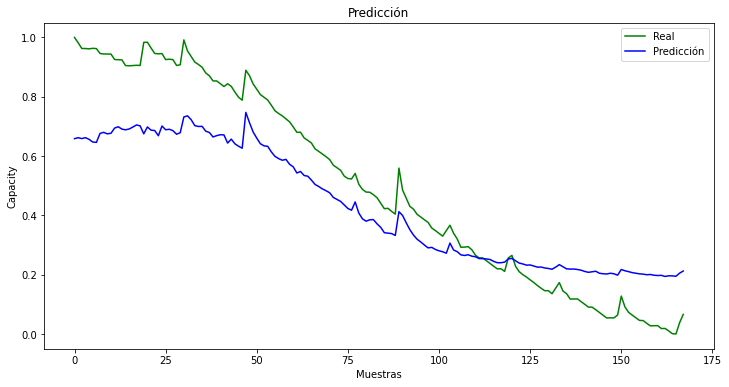

In [ ]:
# Datos de validación
error(model, X_valid, y_valid)
grafico(model, X_valid, y_valid)

RMSE para batería #5 es: 0.15882238651485242.
RMSE para batería #6 es: 0.11121552009072327.
RMSE para batería #7 es: 0.16130564577653.
RMSE para batería #18 es: 0.13632567381925037.


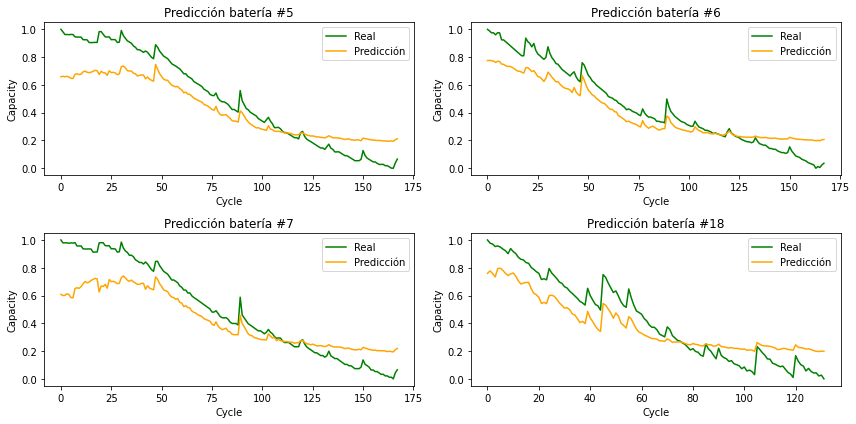

In [ ]:
# Se validan los errores para cada batería y se grafican
grafico_bat(model)

Con el modelo entrenado, se hace la predicción para cada uno de los datos de capacidad de las baterías. El RMSE para la predicción es superior al 10%, por lo que se puede observar un poco de sobreajuste en el modelo, ya que en comparación con los datos de test se obtiene un RMSE menor.

Así mismo, se observa que al final de los ciclos de carga/descarga para cada una de las baterías, la predicción se vuelve de manera lineal y horizontal, por lo que se pierde mayor poder predictivo cuando se está acabando la vida útil de la batería. Esto indica que el modelo no es capaz de capturar los datos al fin de la vida útil y es necesario plantear otro modelo que permita capturar este comportamiento.

Por esto, se plantea un modelo con capas LSTM que permita capturar las dependencias de corto y largo plazo de la capacidad y la predicción mejore.

### *Modelo con capas LSTM y los datos con el promedio*

In [ ]:
# Se implementa un modelo teniendo en cuenta capas LSTM
modelo_LSTM = Sequential()
modelo_LSTM.add(LSTM(128, input_shape = (X_train.shape[1],1), return_sequences=True, activation = "tanh"))
modelo_LSTM.add(LSTM(64, activation = "tanh", return_sequences = True))
modelo_LSTM.add(LSTM(32, activation = "tanh"))
modelo_LSTM.add(Dense(96, activation = "relu"))
modelo_LSTM.add(Dense(128, activation = "relu"))
modelo_LSTM.add(Dense(units=1))

In [ ]:
modelo_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 96)                3168      
                                                                 
 dense_4 (Dense)             (None, 128)               12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 144,097
Trainable params: 144,097
Non-tr

In [ ]:
# Se compila el modelo
modelo_LSTM.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

In [ ]:
# Se entrena el modelo
modelo_LSTM.fit(x=X_train, y=y_train, batch_size=25, epochs=50, verbose= False)

RMSE para los datos es: 0.07983582687290446.


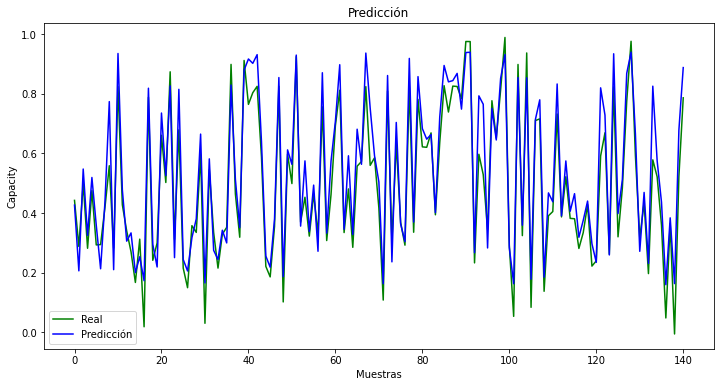

In [ ]:
# Error y gráficas para los datos de testeo
error(modelo_LSTM, X_test, y_test)
grafico(modelo_LSTM, X_test, y_test)

Con el modelo de capas LSTM y densas, se obtienen 144.097 parámetros, lo cual muestra que es un modeo mucho más complejo comparado con el anterior en términos de número de parámetros. Con este modelo, se obtiene un valor del RMSE inferior al 10%, lo cual muestra que el RMSE con este modelo y el anterior es similar. Gráficamente se observa que los valores reales versus los valores predichos en cada una de las muestras de capacidad, se ajusta adecuadamente. Incluso, se observa que con el modelo, las predicciones para los valores picos en cada una de las muestras, se justan mejor en comparación con el modelo anterior.

Se hace la evaluación del modelo entrenado y la predicción para cada una de las baterías y se valida su ajuste y error.

RMSE para batería #5 es: 0.10605796026721426.
RMSE para batería #6 es: 0.06025539565358385.
RMSE para batería #7 es: 0.09578720496408089.
RMSE para batería #18 es: 0.07892770234525191.


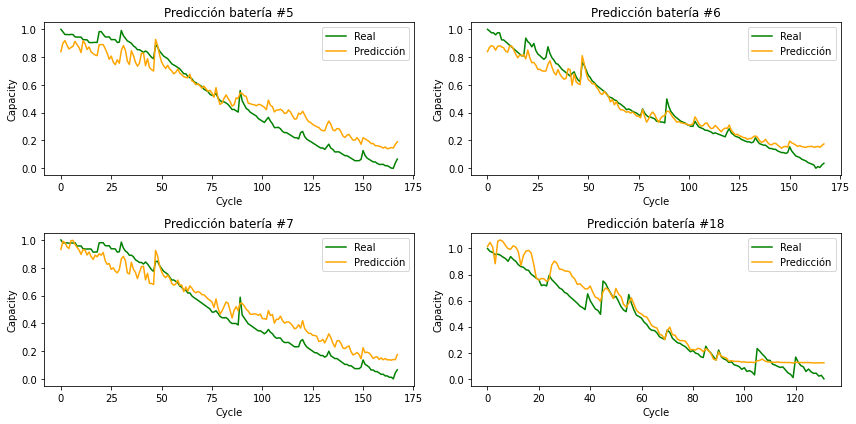

In [ ]:
grafico_bat(modelo_LSTM)

En comparación con el modelo inicial y el modelo planteado con capas LSTM, se observa una mejoría en los resultados del RMSE, ya que los valores obtenidos para el RMSE de cada una de las baterías es menor al 10%. Así mismo, en las gráficas, se observa un mejor ajuste de la predicción en cuanto a los datos reales, en comparación con el modelo inicial de capas densas.

En este modelo, se observa que los valores predichos versus los valores reales se ajustan mejor incluso en los valores finales de ciclos de carga/descarga para cada una de las baterías, excepto para la batería #18, que al final también muestra una predicción lineal y horizontal a partir del ciclo 90.

Esto indica que este modelo tiene mejor poder predictivo en comparación con el modelo anterior.

### *Modelo con capas recurrente y los datos con el promedio*

Se genera un modelo más simple implementando redes recurrentes y una capa de dropout para evitar el sobreajuste en la predicción.

In [ ]:
# The RNN architecture
modelo_RNN = Sequential()
# First RNN layer with Dropout regularisation
modelo_RNN.add(SimpleRNN(50,input_shape=(X_train.shape[1],1), activation = 'relu'))
modelo_RNN.add(Dropout(0.2))
# The output layer
modelo_RNN.add(Dense(units=1))

In [ ]:
modelo_RNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Se compila el modelo
modelo_RNN.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

In [ ]:
# Se entrena el modelo
modelo_RNN.fit(x=X_train, y=y_train, batch_size=25, epochs=50, verbose = False)

RMSE para los datos es: 0.02574248386857636.


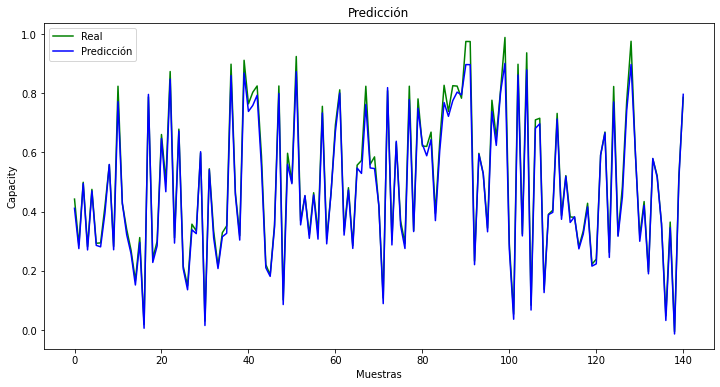

In [ ]:
error(modelo_RNN, X_test, y_test)
grafico(modelo_RNN, X_test, y_test)

Con el modelo de capa recurrente y el dropout para evitar el ajuste, se obtiene un modelo con 2.651 parámetros, lo cual muestra que es un modelo más complejo comparado con el primer modelo propuesto y menos complejo comparado con el modelo anterior que usa capas LSTM.

Con este modelo, se obtiene un valor del RMSE inferior al 5%, lo cual muestra que el RMSE con este modelo se mejora comparado con los modelos anteriores. Gráficamente se observa que los valores reales versus los valores predichos en cada una de las muestras de capacidad, se ajusta adecuadamente, incluso en los picos que se presentan en la capacidad.

Se hace la evaluación del modelo entrenado y la predicción para cada una de las baterías y se valida su ajuste y error.

RMSE para batería #5 es: 0.06473840392754522.
RMSE para batería #6 es: 0.03339995172028581.
RMSE para batería #7 es: 0.08782731215652846.
RMSE para batería #18 es: 0.10558862960208706.


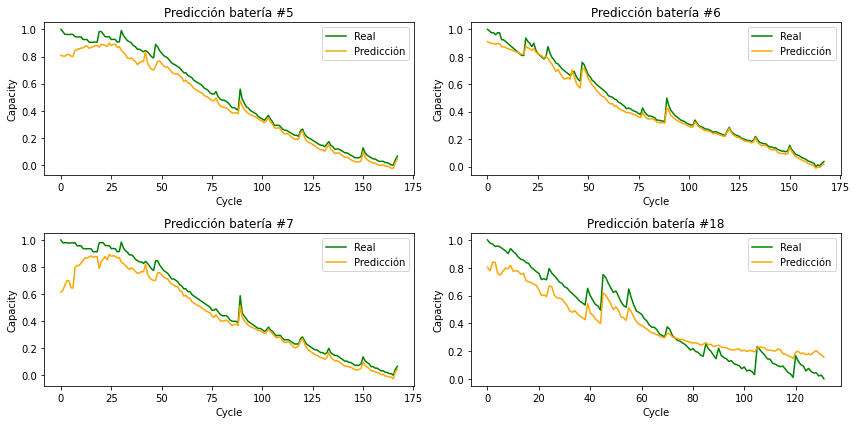

In [ ]:
grafico_bat(modelo_RNN)

Se observa en los resultados obtenidos un mejor ajuste de la predicción a los datos reales de los 4 conjuntos de baterías en comparación con los modelos anteriores.

Comparando los 3 modelos anteriores, se puede concluir que se obtienen mejores resultados con el modelo de la capa recurrente y la capa de dropout que evita el sobreajuste, ya que el RMSE en este modelo es menor, y gráficamente se observa un mejor ajuste de la predicción en comparación con los datos reales para cada una de las baterías. En la batería #18, se observa que la predicción está un poco más alejada de los datos reales, pero se captura el comportamiento decreciente que tiene la capacidad a lo largo de los ciclos de carga/descarga.


## Implementación de los modelos a partir del dataset con la **mediana de los datos**

Inicialmente, se plantean 3 tipos de modelos usando los datos del promedio de las variables de corriente, voltaje y temperatura. En esta sección, se pretende validar los resultados de cada uno de los modelos planteados anteriormente con un nuevo dataset que incluye los datos de la mediana de las variables.

Así como se hizo la división de los datos en la sección de dataset con promedio, se toman los datos de las baterías #6, #7, #18, para hacer el entrenamiento y test y el conjunto de datos de la batería #5 se deja para hacer la validación.

In [ ]:
# Filtrar las baterías 6, 7, 18 para el train y test
datos_model_med = dataset_median[dataset_median['battery'] > 5]
features = ['cycle', 'temperature_measured','voltage_measured','current_measured','voltage_load','current_load','SOH', 'capacity']
train_med, test_med = train_test_split(datos_model_med[features], test_size = 0.30, random_state = 100)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_med_n = scaler.fit_transform(train_med)
test_med_n = scaler.transform(test_med)

In [ ]:
print('Forma train:', train_med.shape, 'Forma test:', test_med.shape)

Forma train: (327, 8) Forma test: (141, 8)


In [ ]:
# Se definen los datos de entrenamiento en: Predictores y predicho
X_train_med = train_med_n[:, :7]
y_train_med = train_med_n[:,7:8]
# Se definen los datos de test en: Predictores y predicho
X_test_med = test_med_n[:, :7]
y_test_med = test_med_n[:,7:8]

In [ ]:
# Se valida la forma de cada uno de los datos de entrenamiento y test
print('X train:', X_train_med.shape, 'y train:', y_train_med.shape)
print('X test:', X_test_med.shape, 'y test:', y_test_med.shape)

X train: (327, 7) y train: (327, 1)
X test: (141, 7) y test: (141, 1)


In [ ]:
# Datos de validación con la batería 5
datos_valid_med = dataset_median[dataset_median['battery'] == 5]
datos_valid_med = datos_valid_med[features]
# Se normaliza el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
validation_med = scaler.fit_transform(datos_valid_med)
print(validation_med.shape)
# Se hace la división de los datos
X_valid_med = validation_med[:, :7]
y_valid_med = validation_med[:,7:8]

(168, 8)


In [ ]:
# Se valida la forma de cada uno de los datos de entrenamiento y test
print(X_valid_med.shape, y_valid_med.shape)

(168, 7) (168, 1)


In [ ]:
# Para validar resultados con los datos de las baterías
# Datos de la batería 6
datos_6_med = dataset_median[dataset_median['battery'] == 6]
datos_6_med = datos_6_med[features]
# Se normaliza el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
val_6_med = scaler.fit_transform(datos_6_med)
# Se hace la división de los datos
X_bat6_med = val_6_med[:, :7]
y_bat6_med = val_6_med[:,7:8]

# Datos de la batería 7
datos_7_med = dataset_median[dataset_median['battery'] == 7]
datos_7_med = datos_7_med[features]
# Se normaliza el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
val_7_med = scaler.fit_transform(datos_7_med)
# Se hace la división de los datos
X_bat7_med = val_7_med[:, :7]
y_bat7_med = val_7_med[:,7:8]

# Datos de la batería 18
datos_18_med = dataset_median[dataset_median['battery'] == 18]
datos_18_med = datos_18_med[features]
# Se normaliza el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
val_18_med = scaler.fit_transform(datos_18_med)
# Se hace la división de los datos
X_bat18_med = val_18_med[:, :7]
y_bat18_med = val_18_med[:,7:8]

### *Modelo con capas densas y los datos con la mediana*

In [ ]:
# Se compila el modelo
model.compile(optimizer='adam', loss='mean_absolute_error')
# Se entrena el modelo
model.fit(x=X_train_med, y=y_train_med, batch_size=25, epochs=50, verbose = False)

RMSE para los datos es: 0.09027988838721715.


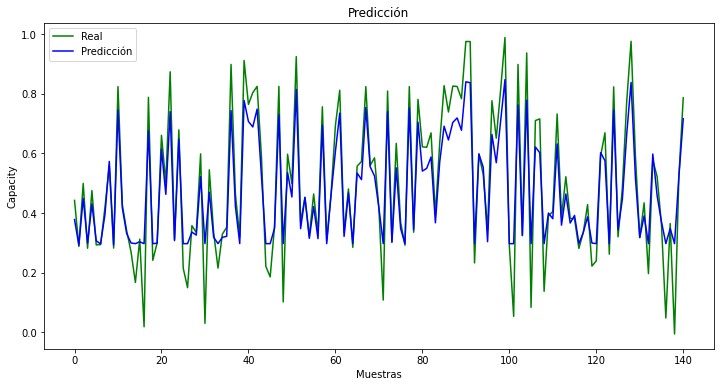

In [ ]:
# Datos de test
error(model, X_test_med, y_test_med)
grafico(model, X_test_med, y_test_med)

Con el modelo inicial, de 145 parámetros, se obtiene un valor del RMSE inferior al 10%, similar al RMSE obtenido con el promedio de los datos de las variables corriente, voltaje y temperatura. Gráficamente se observa que los valores reales versus los valores predichos en cada una de las muestras de capacidad, se ajusta adecuadamente, sin embargo, se observa que con el modelo no se ajusta muy bien a los picos que se presentan en cada una de las muestras, como se observó con el promedio de los datos.

Por el momento, el test de los modelos y las gráficas usando el promedio y la mediana pareciera tener el mismo impacto en los resultados de la predicción y el error obtenido.

Se hace la evaluación del modelo entrenado con los datos de validación y se hace la predicción para cada una de las baterías y validar su ajuste.

RMSE para batería #5 es: 0.14815293371868846.
RMSE para batería #6 es: 0.11072025382652675.
RMSE para batería #7 es: 0.14389108265491207.
RMSE para batería #18 es: 0.13537636958964083.


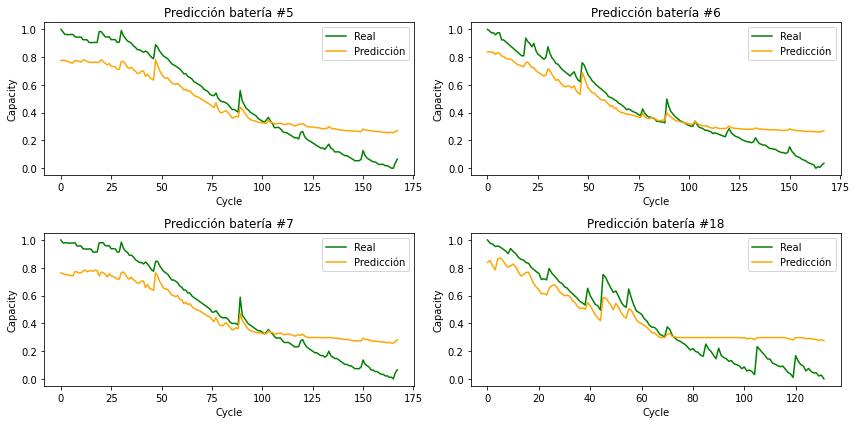

In [ ]:
grafico_bat(model)

Se entrena el modelo con los datos de cada una de las baterías y se observa que el RMSE para la predicción es superior al 10%, como se obtuvo en el modelo inicial anterior.

Así mismo, se observa el mismo comportamiento obtenido en el modelo inicial con el promedio de los datos; Al final de los ciclos de carga/descarga para cada una de las baterías, la predicción se vuelve de manera lineal y horizontal, por lo que se pierde mayor poder predictivo cuando se está acabando la vida útil de la batería.

### *Modelo con capas LSTM y los datos con la mediana*

In [ ]:
# Se compila el modelo
modelo_LSTM.compile(optimizer='adam', loss='mean_absolute_error')
# Se entrena el modelo
modelo_LSTM.fit(x=X_train_med, y=y_train_med, batch_size=25, epochs=50, verbose = False)

RMSE para los datos es: 0.05062498150668144.


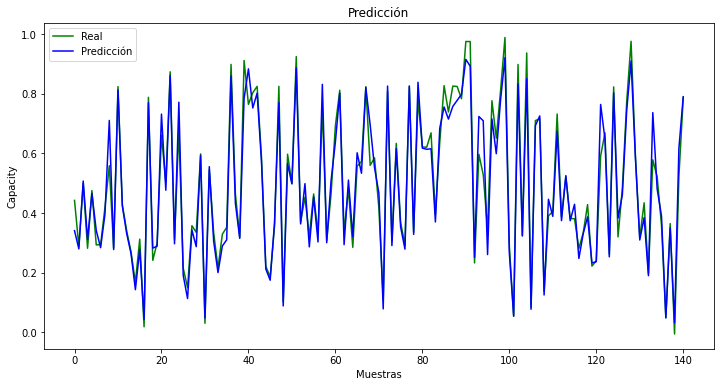

In [ ]:
# Datos de test
error(modelo_LSTM, X_test_med, y_test_med)
grafico(modelo_LSTM, X_test_med, y_test_med)

Se entrena el modelo y se hace la predicción y se obtiene un RMSE inferior al 10%, incluso, se obtiene un RMSE mejor en comparación con el modelo con capas LSTM usando el promedio de los datos.

Así mismo, se ve una mejoría en el RMSE en comparación con el modelo anterior. Gráficamente se observa que los valores reales versus los valores predichos en cada una de las muestras de capacidad, se ajusta adecuadamente. Incluso, también se observa que con el modelo, las predicciones para los valores picos en cada una de las muestras, se justan mejor en comparación con el modelo anterior.

Se hace la evaluación del modelo entrenado y la predicción para cada una de las baterías y se valida su ajuste y error.

RMSE para batería #5 es: 0.11610336994159094.
RMSE para batería #6 es: 0.07268161416174367.
RMSE para batería #7 es: 0.11015276005897821.
RMSE para batería #18 es: 0.08982039220295596.


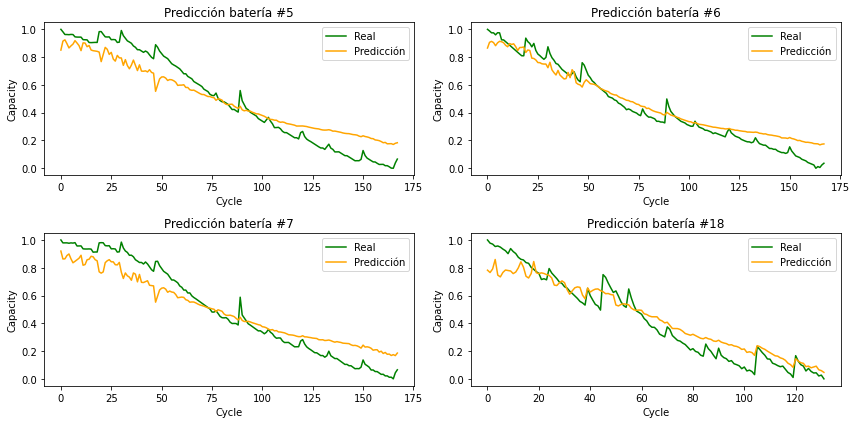

In [ ]:
grafico_bat(modelo_LSTM)

En comparación con el modelo inicial y el modelo usando la mediana de los datos, se observa una mejoría en los resultados del RMSE, ya que los valores obtenidos para el RMSE de cada una de las baterías es menor al 11%. Así mismo, en las gráficas, se observa un mejor ajuste de la predicción en cuanto a los datos reales, en comparación con el modelo inicial de capas densas.

En este modelo, se observa que la predicción con la mediana de los datos, se suaviza más a lo largo de los ciclos de carga/descarga, en comparación con el modelo LSTM usando el promedio de los datos. Así mismo, se observa que los valores predichos versus los valores reales se ajustan mejor incluso en los valores finales de ciclos de carga/descarga para cada una de las baterías, incluso para la batería #18, la cual no estaba teniendo una buena predicción con el modelo LSTM usando el promedio de los datos.

Esto indica que este modelo tiene mejor poder predictivo en comparación con el modelo anterior de capas densas.

### *Modelo con capas recurrente y los datos con la mediana*

In [ ]:
# Se compila el modelo
modelo_RNN.compile(optimizer='adam', loss='mean_absolute_error')
# Se entrena el modelo
modelo_RNN.fit(x=X_train_med, y=y_train_med, batch_size=25, epochs=50, verbose = False)

RMSE para los datos es: 0.026954458343719716.


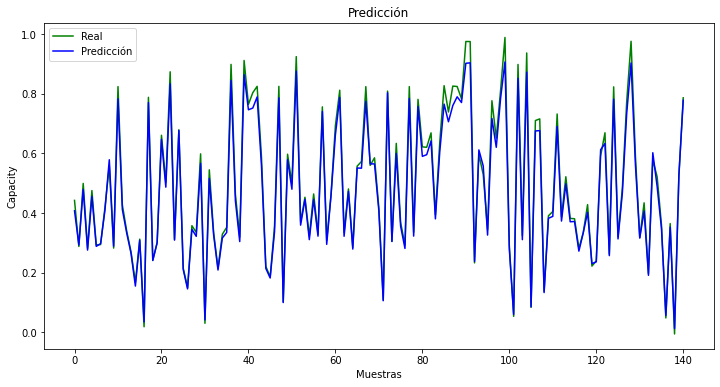

In [ ]:
# Datos de test
error(modelo_RNN, X_test_med, y_test_med)
grafico(modelo_RNN, X_test_med, y_test_med)

Se entrena el modelo y se evalúa el RMSE, el cual es inferior al 5% y similar al resultado obtenido en el modelo de recurrencia usando el promedio de los datos. Gráficamente se observa que los valores reales y los valores predichos en cada una de las muestras de capacidad, se ajustan adecuadamente, incluso en los picos que se presentan.

Se hace la evaluación del modelo entrenado y la predicción para cada una de las baterías y se valida su ajuste y error.


RMSE para batería #5 es: 0.08015831969835725.
RMSE para batería #6 es: 0.05336504859504523.
RMSE para batería #7 es: 0.07991193794612565.
RMSE para batería #18 es: 0.1407013402012523.


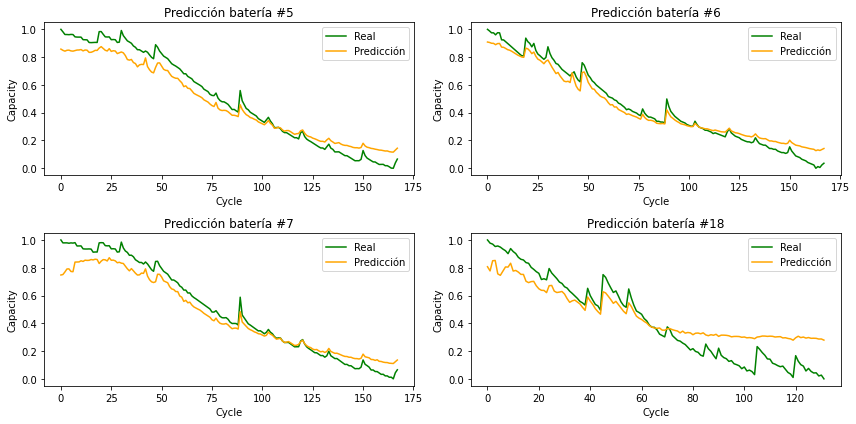

In [ ]:
grafico_bat(modelo_RNN)

Se observa en los resultados obtenidos un mejor ajuste de la predicción a los datos reales de los 4 conjuntos de baterías en comparación con los modelos anteriores.

Sin embargo, cuando se comparan los resultados de este modelo usando la mediana y el promedio de los datos, se observa que usando los datos de la mediana, se obtiene una predicción más suavizada. Para la batería #18, se observa que la predicción sigue estando un poco más alejada de los datos reales, y  el comportamiento decreciente que tiene la capacidad a lo largo de los ciclos de carga/descarga no es tan bien capturado como en el modelo que se emplea el promedio de los datos.


**Conclusión:**

Se plantean 3 modelos con diferentes complejidades y se observa que el modelo con una complejidad media en cuanto al número de parámetros que tiene ofrece mejores resultados en la predicción de la capacidad para ambos conjuntos de datos: promedio y mediana.

Se observa en los modelos en los que se usó la mediana de los datos, que la predicción tiende a suavizarse más, en comparación con los resultados obtenidos en los modelos usando el promedio de los datos.

Se logra en general un RMSE inferior al 10% para el conjunto de datos de las baterías con el modelo que emplea una capa de recurrencia y una capa de dropout. Este modelo se ajusta adecuadamente a los datos reales de la degradación de la capacidad (vida útil) de las baterías. Sin embargo, para la batería #18, que tiene un comportamiento de degradación más acelerado, se observa que con el modelo de recurrencia se logra un RMSE inferior al 15% y se captura mejor su comportamiento usando el promedio de los datos, ya que usando la mediana de los datos, el modelo tiende a suavizar la predicción en los últimos ciclos de carga/descarga y no se captura bien el comportamiento decreciente de los datos.